# Ejercicio

# Caso real: Citations

Probaremos la red en un dataset real con una tarea real, prediccion de la categoria de un paper segun la red de citas.

* Los nodos son articulos
* Las aristas son citas entre articulos
* Los atributos de los nodos representan el texto del articulo.
* Predecir una categoria de entre 7 posibles

Mensaje: identidad, z
Agregacion: suma
update: MLP (un parametro), (i+...) (segundo parametro) y lo que resulta de la agregacion (es agg_out)

todo lo que dependa de zv, tiene que ser la agregacion: lo que afecta al mensaje (la suma)
v son vecinos de u, vienen de la capa anterior.

u es el nodo actual


---

MSG: identidad
UPDATE: MLP ((..epsilon ...)
AGGR: Suma


## Cargar dataset

In [16]:
from torch_geometric.datasets import CitationFull

dataset = CitationFull(root='CitationFull', name='Cora_ML')
print(f"Number of graphs: {len(dataset)}")

data = dataset[0]
print(f"Attributes: {data.keys()}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
print(f"Number of edge features: {data.num_edge_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Contains isolated nodes: {data.has_isolated_nodes()}")
print(f"Contains self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Processing...


Number of graphs: 1
Attributes: ['y', 'x', 'edge_index']
Number of nodes: 2995
Number of edges: 16316
Number of node features: 2879
Number of edge features: 0
Number of classes: 7
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


Done!


## Definir una capa nueva de paso de mensajes

$$
z_u^l = \text{MLP}_{\theta}^l \left( \left( 1 + \epsilon^l \right) \odot z_u^{l-1} + \sum_{v \in \mathcal{N}(u)} z_v^{l-1} \right)
$$

In [27]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
from torch_geometric.nn import  MLP

class GIN(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GIN, self).__init__(aggr='sum') # ya viene implementado la agg de suma
        
        self.mlp = MLP(
            in_channels = in_channels,
            out_channels = out_channels,
            hidden_channels = 32,
            num_layer = 2
        )
        self.epsilon = Parameter(torch.tensor([0,0]))
        
        self.reset_parameters()

    def reset_parameters(self):
        self.mlp.reset_parameter()
        self.epsilon.fill_(0.5)

    def forward(self, x, edge_index):
        
        return self.propagate(edge_index, x=x, central_node=x) # pasamos central_node
    
    def message(self, x_j):
        return x_j
    
    def update(self, aggr_out, central_node): # se accede a central_node porque se pasa en el forward
        upd = (1 + self.epsilon)+central_node+aggr_out
        return aggr_out

In [ ]:
import torch
from torch_geometric.nn import GCNConv, MLP, JumpingKnowledge
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.jk = JumpingKnowledge(mode='cat')
        self.cls = MLP(in_channels=hidden_channels*2, out_channels=num_classes, num_layers=1) # 2 es el numero de capas, para generalizar , n capas

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x_1 = F.relu(x)
        x = self.conv2(x, edge_index)
        x_2 = F.relu(x)
        x = self.jk([x_1, x_2])
        x = self.cls(x)
        return x

C:\Users\Angel Panizo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] No se encontró el proceso especificado
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\Angel Panizo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] No se encontró el proceso especificado
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
C:\Users\Angel Panizo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occur

## Cargar dataset

In [2]:
from torch_geometric.datasets import CitationFull

dataset = CitationFull(root='CitationFull', name='Cora_ML')
print(f"Number of graphs: {len(dataset)}")

data = dataset[0]
print(f"Attributes: {data.keys()}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
print(f"Number of edge features: {data.num_edge_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Contains isolated nodes: {data.has_isolated_nodes()}")
print(f"Contains self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Number of graphs: 1
Attributes: ['y', 'edge_index', 'x']
Number of nodes: 2995
Number of edges: 16316
Number of node features: 2879
Number of edge features: 0
Number of classes: 7
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Dividir dataset

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(np.arange(data.num_nodes), test_size=0.2, stratify=data.y)

train_mask = np.zeros(data.num_nodes, dtype=bool)
train_mask[train_idx] = True

test_mask = np.zeros(data.num_nodes, dtype=bool)
test_mask[test_idx] = True

data.train_mask = torch.tensor(train_mask)
data.test_mask = torch.tensor(test_mask)

## Train

In [4]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

model = GCN(dataset.num_node_features, 16, dataset.num_classes)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
optm_func = CrossEntropyLoss()

model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = optm_func(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")

Epoch 0: Loss 1.946506142616272
Epoch 10: Loss 0.6916095018386841
Epoch 20: Loss 0.22733713686466217
Epoch 30: Loss 0.12355022132396698
Epoch 40: Loss 0.07788509130477905
Epoch 50: Loss 0.0606655590236187
Epoch 60: Loss 0.052503932267427444
Epoch 70: Loss 0.04603101313114166
Epoch 80: Loss 0.04296857491135597
Epoch 90: Loss 0.03912689536809921
Epoch 100: Loss 0.03305814415216446
Epoch 110: Loss 0.030634598806500435
Epoch 120: Loss 0.028691373765468597
Epoch 130: Loss 0.02711031213402748
Epoch 140: Loss 0.03307686373591423
Epoch 150: Loss 0.024179399013519287
Epoch 160: Loss 0.02317662350833416
Epoch 170: Loss 0.02255486510694027
Epoch 180: Loss 0.021733896806836128
Epoch 190: Loss 0.021654780954122543
Epoch 200: Loss 0.020666340366005898
Epoch 210: Loss 0.019614452496170998
Epoch 220: Loss 0.018810318782925606
Epoch 230: Loss 0.018314190208911896
Epoch 240: Loss 0.01861388050019741
Epoch 250: Loss 0.01805298961699009
Epoch 260: Loss 0.020135799422860146
Epoch 270: Loss 0.01857263781130

## Test model

F1 score: 0.8631051752921536


<Axes: >

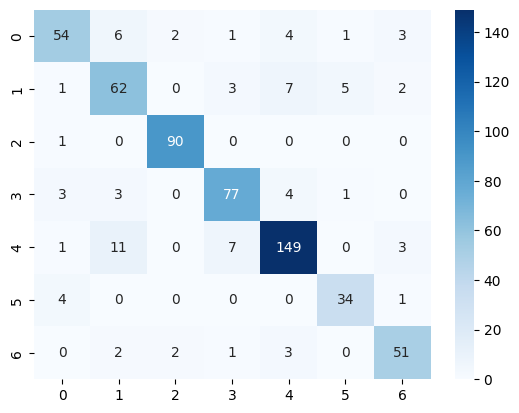

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

model.eval()
y_pred = out.argmax(dim=1)[data.test_mask].detach().cpu()
y = data.y[data.test_mask].detach().cpu()

print(f"F1 score: {f1_score(y, y_pred, average='micro')}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')